**Regression**

In [1]:
import os
import sys

from pathlib import Path

import numpy as np
import pandas as pd
import math
from math import exp

import scipy
from sklearn import linear_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.insert(0, os.path.join('.', "..", '..','calibration'))

In [3]:
import thermodynamics
from CoolProp.HumidAirProp import HAPropsSI

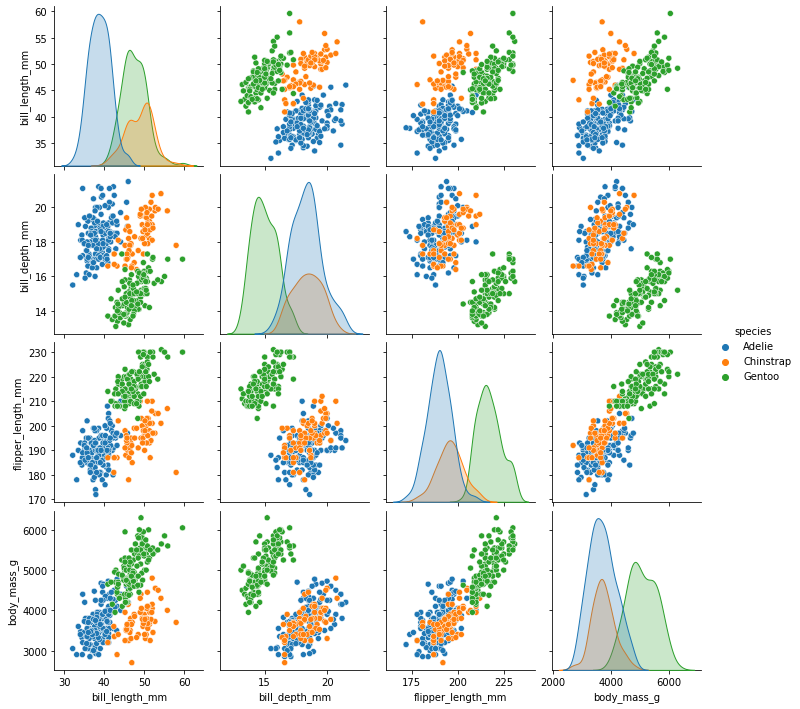

In [31]:
df = sns.load_dataset('penguins')
sns.pairplot(df, hue='species')

In [4]:
patha_sim_output = os.path.join(os.path.expanduser("~"), "GIT", "TheGreeFa_EnBA", "Data_input", "simulation_results")

# regression

In [9]:
def calc_R_squared(data_ref, data_cal):
    '''
    R squared: coefficient of determination = 1 - SSR/SST    
    '''
    np_li_ref = np.array(data_ref)
    np_li_cal = np.array(data_cal)
    mean_ref = np.mean(np_li_ref)
    SST = np.sum((np_li_ref-mean_ref)**2)
    SSR = np.sum((np_li_ref-np_li_cal)**2)

    r_value = 1 - SSR/SST

    return r_value

## Nu Sh Regression

### convert dataframe to regression-readable format

- questions:
    - what is Nu2 and Sh2 for?

In [46]:
def generate_regression_input(file_path_name, sorted_by = None, if_cooling = True, if_log=True, point_exclude = [], critera = 2,):
        
    df_input_raw = pd.read_csv(filepath_or_buffer=file_path_name, index_col=0).drop(point_exclude)

    if if_cooling:
        df_input = df_input_raw.query("(T_a_in - T_d_in) >{}".format(critera))
        print("number of cooling datapoint is {} \n".format(df_input.shape[0]))
        print("following datasets are excluded from regression: \n {}.".format(set(df_input_raw.index)-set(df_input.index)))

    df_input_selected = df_input[['T_a_in', 'x_a_in', 'm_a_in', 'T_d_in', "xi_d_in", 'x_d_in_equ', 'm_d_in', 'T_a_o_exp', 'T_d_o_exp', 'x_a_o_exp', 'Re', 'Pr', 'Sc', 'Nu', 'Sh']]

    try:
        df_input_selected["Nu_2"] = df_input["Nu_2"]
        df_input_selected["Sh_2"] = df_input["Sh_2"]
    except:
        print("no Nu_2 and Sh_2 in dataframe.")

    if if_log:
        df_input_selected['log_Re'] = (df_input_selected['Re']/2300).apply(math.log)
        df_input_selected['log_Pr'] = df_input_selected['Pr'].apply(math.log)
        df_input_selected['log_Sc'] = df_input_selected['Sc'].apply(math.log)
        df_input_selected['log_m_frac'] = np.vectorize(lambda x,y: math.log(y/x))(df_input_selected.m_a_in, df_input_selected.m_d_in)
        df_input_selected['log_x_frac'] = np.vectorize(lambda x,y: math.log(1-y/x))(df_input_selected.x_a_in, df_input_selected.x_d_in_equ)
        df_input_selected['log_T_frac'] = np.vectorize(lambda x,y: math.log(y/x))(df_input_selected.T_a_in-273.15, df_input_selected.T_d_in-273.15)

        df_input_selected['log_Nu'] = df_input_selected['Nu'].apply(math.log)
        df_input_selected['log_Sh'] = df_input_selected['Sh'].apply(math.log)
        try:
            df_input_selected['log_Nu_2'] = df_input_selected['Nu_2'].apply(math.log)
            df_input_selected['log_Sh_2'] = df_input_selected['Sh_2'].apply(math.log)
            print("logarithm for Nu_2, Sh_2 generated")
        except:
            print("no Nu_2 and Sh_2 in dataframe.")

    try:
        df_input_selected.sort_values(by=sorted_by, ascending=True, inplace = True)
    except:
        print("###### use unsorted calibration data ######")

    return df_input_selected

### configurate regression

In [52]:
def func_Nu(variables, a, b, c, d, e, f, if_normalise = True):
    if if_normalise:
        Re = variables['Re'].to_numpy()/2300
    else:
        Re = variables['Re'].to_numpy()
    Pr = variables['Pr'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()

    Nu = a * np.power(Re, b) * np.power(Pr, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f)
    # Nu = a * np.power(Re, b) * np.power(Pr, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f) # adjusted for absorption
    # if used for regeneration, some of the sign needs to be altered.

    return Nu

def func_Sh(variables, a, b, c, d, e, f, if_normalise = True):
    if if_normalise:
        Re = variables['Re'].to_numpy()/2300
    else:
        Re = variables['Re'].to_numpy()
    Sc = variables['Sc'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()

    Sh = a * np.power(Re, b) * np.power(Sc, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f)

    return Sh

In [53]:
#[1,1,1,1,1,1]
def regr_via_scipy(df, target, p0 = [0,0,0,0,0,0], sigma_ratio = None, abs_sigma = False, iter_num = 2000, method = 'lm'):
    if sigma_ratio is not None:
        sigma = df[target].to_numpy()*sigma_ratio        
    else:
        sigma = None
    if target[0:2] == "Nu":
        results = scipy.optimize.curve_fit(func_Nu2, df, df[target].to_numpy(), p0=p0, sigma=sigma, absolute_sigma = abs_sigma, maxfev = iter_num, method = method)
    elif target[0:2] == "Sh":
        results = scipy.optimize.curve_fit(func_Sh, df, df[target].to_numpy(), p0=p0, sigma=sigma, absolute_sigma = abs_sigma, maxfev = iter_num, method = method)
    else:
        print("Target can only be 'Nu' or 'Sh'.")
    return results
#[1, 1.8, 1/3, -1, 0.8, 0.4] check different p0 (initial guess of the parameter), actually made no big difference..

In [54]:
def func_Nu2(variables, a, b, c, d, e, f, if_normalise = True):
    if if_normalise:
        Re = variables['Re'].to_numpy()/2300
    else:
        Re = variables['Re'].to_numpy()
    Pr = variables['Pr'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()

    Nu = a * np.power(Re, b) * np.power(Pr, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), 0)
    # Nu = a * np.power(Re, b) * np.power(Pr, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f) # adjusted for absorption
    # if used for regeneration, some of the sign needs to be altered.

    return Nu

### check validity of regression method scipy using Chen's data and input parameter (Re, Pr, etc.) read from Modelica
- results: the scipy regression performed well

In [10]:
df_input = generate_regression_input('./data_for_regression/chen_original_data.csv', if_log=False, )

number of cooling datapoint is 15 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


In [9]:
popt, pcov = regr_via_scipy(df=df_input, target='Nu', iter_num=20000)

In [10]:
popt

array([ 4.77554767e-05,  1.79360145e+00,  3.33298192e-01, -1.00099958e+00,
        8.19799389e-01,  3.84600216e-01])

In [11]:
pcov

array([[ 2.73920344e-19, -4.14686014e-16,  8.85690364e-15,
         2.50428987e-16,  2.86726021e-16, -1.22430780e-16],
       [-4.14686014e-16,  2.59816173e-12,  3.10524552e-11,
         1.09250789e-12, -9.95132294e-13,  1.28839621e-13],
       [ 8.85690364e-15,  3.10524552e-11,  1.29290540e-09,
         4.34264668e-11, -4.04195239e-12, -5.33217138e-12],
       [ 2.50428987e-16,  1.09250789e-12,  4.34264668e-11,
         2.83842119e-12, -4.45844757e-13, -2.30355842e-13],
       [ 2.86726021e-16, -9.95132294e-13, -4.04195239e-12,
        -4.45844757e-13,  7.66714940e-13, -1.46654343e-13],
       [-1.22430780e-16,  1.28839621e-13, -5.33217138e-12,
        -2.30355842e-13, -1.46654343e-13,  9.95683683e-14]])

In [12]:
results_from_regr = func_Nu(df_input, *popt)

In [13]:
calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr)

0.9999999999994523

In [14]:
popt2, pcov2 = regr_via_scipy(df=df_input, target='Sh', iter_num=20000)

In [15]:
results_from_regr_Sh = func_Sh(df_input, *popt2)

In [16]:
calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh)

0.999999999996936

### check if it possible to get a proper formular to reproduce the Nu Sh generated by iteration

**prepare data**

In [14]:
df_ori = pd.read_csv(os.path.join(path_sim_output, 'final_output_calib.csv'), index_col=0)

In [17]:
df_selected = df_ori[['T_a_in', 'x_a_in', 'm_a_in', 'T_d_in', "xi_d_in", 'x_d_in_equ', 'm_d_in', 'Re', 'Pr', 'Sc', 'Nu_iter', 'Sh_iter']]

In [18]:
dict_rename = {'Nu_iter':'Nu',
              'Sh_iter':'Sh',}
df_selected = df_selected.rename(columns = dict_rename)
df_selected.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,Re,Pr,Sc,Nu,Sh
1,298.75,0.0162,1.85,288.05,0.2300,0.007228,2.61,996.698754,0.723822,0.616835,3.662364,3.251291
10,297.15,0.0152,1.94,289.95,0.2961,0.006049,2.82,1048.989749,0.722987,0.616519,4.363029,3.334007
11,297.35,0.0160,1.98,290.85,0.3007,0.006254,2.85,1070.471776,0.723793,0.616603,5.023988,3.700249
12,298.25,0.0152,1.94,291.25,0.3052,0.006259,2.90,1046.027445,0.722846,0.616694,4.487529,3.472546
13,298.35,0.0143,1.95,290.95,0.3182,0.005690,2.85,1050.698532,0.721900,0.616654,4.655537,3.399286


In [64]:
# df_selected.to_csv('cleaned_calib.csv')

#### **regression**

In [20]:
df_input = generate_regression_input(os.path.join(path_sim_output, 'cleaned_calib.csv'), if_log=False, )

number of cooling datapoint is 15 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


In [21]:
df_input.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,T_a_o_exp,T_d_o_exp,x_a_o_exp,Re,Pr,Sc,Nu,Sh
1,298.75,0.0162,1.85,288.05,0.2300,0.007228,2.61,292.35,294.45,0.0091,996.698754,0.723822,0.616835,3.662364,3.251291
10,297.15,0.0152,1.94,289.95,0.2961,0.006049,2.82,293.25,296.25,0.0075,1048.989749,0.722987,0.616519,4.363029,3.334007
11,297.35,0.0160,1.98,290.85,0.3007,0.006254,2.85,294.05,297.05,0.0077,1070.471776,0.723793,0.616603,5.023988,3.700249
12,298.25,0.0152,1.94,291.25,0.3052,0.006259,2.90,294.45,297.25,0.0075,1046.027445,0.722846,0.616694,4.487529,3.472546
13,298.35,0.0143,1.95,290.95,0.3182,0.005690,2.85,294.25,297.05,0.0069,1050.698532,0.721900,0.616654,4.655537,3.399286


**Nu**

In [22]:
# without considering uncertainty
popt_Nu0, pcov_Nu0 = regr_via_scipy(df=df_input, target='Nu', sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [23]:
popt_Nu0

array([148.10097093,   0.49846925,   7.74354428,   0.99886351,
         1.8923936 ,   0.        ])

In [24]:
results_from_regr_Nu0 = func_Nu(df_input, *popt_Nu0)
calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu0)

0.6604825417936641

In [25]:
# with considering uncertainty
popt_Nu1, pcov_Nu1 = regr_via_scipy(df=df_input, target='Nu', sigma_ratio=0.2, abs_sigma=True, iter_num=20000, method='lm')

In [26]:
popt_Nu1

array([27.34987444, -0.18144436,  3.50631501,  0.77959626,  2.17997769,
        0.        ])

In [27]:
results_from_regr_Nu1 = func_Nu(df_input, *popt_Nu1)
calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu1)

0.6452801762345304

In [28]:
df_input['Nu_0'] = results_from_regr_Nu0
df_input['Nu_1'] = results_from_regr_Nu1

**Sh**

In [29]:
# without uncertainty
popt_Sh0, pcov_Sh0 = regr_via_scipy(df=df_input, target='Sh', sigma_ratio=None, abs_sigma=True, iter_num=20000)
results_from_regr_Sh0 = func_Sh(df_input, *popt_Sh0)
calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh0)

0.5651517386621407

In [30]:
# with uncertainty = 0.2 Sh
popt_Sh1, pcov_Sh1 = regr_via_scipy(df=df_input, target='Sh', sigma_ratio=0.2, abs_sigma=True, iter_num=20000)
results_from_regr_Sh1 = func_Sh(df_input, *popt_Sh1)
calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh1)

0.547531568160417

In [31]:
df_input['Sh_0'] = results_from_regr_Sh0
df_input['Sh_1'] = results_from_regr_Sh1

In [46]:
# df_input.to_csv('regression_chen.csv')

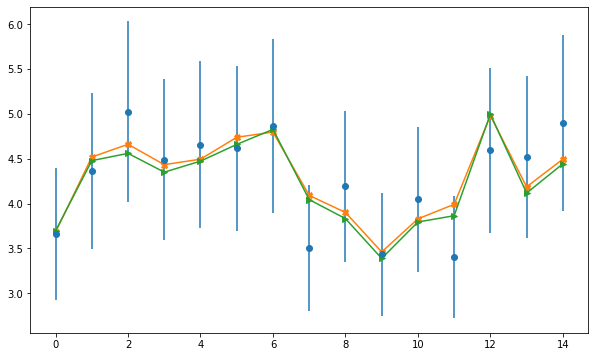

In [32]:
# error bar plot of Nu
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_input.reset_index().index, df_input.reset_index()['Nu'], df_input.reset_index()['Nu']*0.2, fmt = 'o')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Nu_0'], marker = 'X')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Nu_1'], marker = '>')

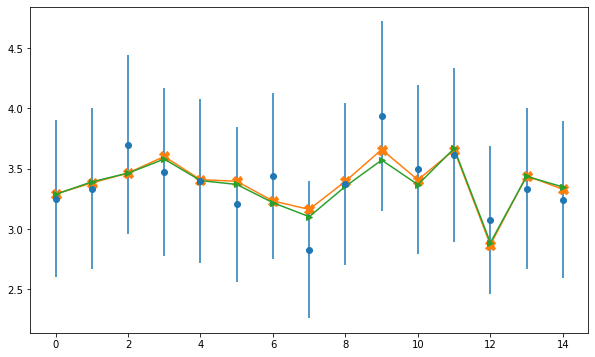

In [33]:
# error bar plot of Sh
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_input.reset_index().index, df_input.reset_index()['Sh'], df_input.reset_index()['Sh']*0.2, fmt = 'o')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Sh_0'], marker = 'X', markersize = 10)
ax.plot(df_input.reset_index().index, df_input.reset_index()['Sh_1'], marker = '>')

## alpha beta regression

In [34]:
def generate_regression_input(file_path_name, sorted_by = None, if_cooling = True, point_exclude = [], critera = 2,):
        
    df_input_raw = pd.read_csv(filepath_or_buffer=file_path_name, index_col=0).drop(point_exclude)

    if if_cooling:
        df_input = df_input_raw.query("(T_a_in - T_d_in) >{}".format(critera))
        print("number of cooling datapoint is {} \n".format(df_input.shape[0]))
        print("following datasets are excluded from regression: \n {}.".format(set(df_input_raw.index)-set(df_input.index)))

    df_input_selected = df_input[['T_a_in', 'x_a_in', 'm_a_in', 'T_d_in', "xi_d_in", 'x_d_in_equ', 'm_d_in', 'T_a_o_exp', 'T_d_o_exp', 'x_a_o_exp', 'Re_cal', 'Pr_cal', 'Sc_cal', 'alpha', 'beta']]

    try:
        df_input_selected.sort_values(by=sorted_by, ascending=True, inplace = True)
    except:
        print("###### use unsorted calibration data ######")

    return df_input_selected

In [35]:
def func_alpha(variables, a, b, c, d, e, f, if_normalise = True):
    if if_normalise:
        Re = variables['Re_cal'].to_numpy()/2300
    else:
        Re = variables['Re_cal'].to_numpy()
    Pr = variables['Pr_cal'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()

    alpha = a * np.power(Re, b) * np.power(Pr, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f)
    # Nu = a * np.power(Re, b) * np.power(Pr, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f) # adjusted for absorption
    # if used for regeneration, some of the sign needs to be altered.

    return alpha

def func_beta(variables, a, b, c, d, e, f, if_normalise = True):
    if if_normalise:
        Re = variables['Re_cal'].to_numpy()/2300
    else:
        Re = variables['Re_cal'].to_numpy()
    Sc = variables['Sc_cal'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()

    beta = a * np.power(Re, b) * np.power(Sc, c) * np.power(m_d/m_a, d) * np.power((1-w_d/w_a), e) * np.power((T_d-273.15)/(T_a-273.15), f)

    return beta

In [36]:
def regr_via_scipy(df, target, p0 = [1,1,1,1,1,1], sigma_ratio = None, abs_sigma = False, iter_num = 2000, method = 'lm'):
    if sigma_ratio is not None:
        sigma = df[target].to_numpy()*sigma_ratio        
    else:
        sigma = None
    if target == "alpha":
        results = scipy.optimize.curve_fit(func_alpha, df, df[target].to_numpy(), p0=p0, sigma=sigma, absolute_sigma = abs_sigma, maxfev = iter_num, method = method)
    elif target == "beta":
        results = scipy.optimize.curve_fit(func_beta, df, df[target].to_numpy(), p0=p0, sigma=sigma, absolute_sigma = abs_sigma, maxfev = iter_num, method = method)
    else:
        print("Target can only be 'Nu' or 'Sh'.")
    return results
#[1, 1.8, 1/3, -1, 0.8, 0.4] check different p0 (initial guess of the parameter), actually made no big difference..

# Regression with data

## dempav alpha beta

In [38]:
df_input = generate_regression_input(os.path.join(path_sim_output, "final_output_alpha_beta.csv"), point_exclude=[5, 14])

number of cooling datapoint is 14 

following datasets are excluded from regression: 
 set().
###### use unsorted calibration data ######


In [39]:
df_input

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,T_a_o_exp,T_d_o_exp,x_a_o_exp,Re_cal,Pr_cal,Sc_cal,alpha,beta
0,298.02,0.009457,0.018848,287.44,0.318302,0.004515,0.102670,290.21,286.230,0.005773,663.427646,0.716941,0.616288,3.885351,0.003807
1,300.51,0.012683,0.036283,292.20,0.318186,0.006170,0.102670,294.81,290.092,0.008716,1270.967647,0.719955,0.616900,5.039243,0.004909
18,291.66,0.006289,0.018106,282.41,0.276896,0.004029,0.104689,287.64,281.917,0.004805,647.100914,0.714521,0.614921,2.929241,0.002882
19,297.19,0.007873,0.043522,284.42,0.323335,0.003572,0.049907,292.08,281.459,0.006467,1534.073345,0.715421,0.616040,2.506157,0.002458
2,298.02,0.009022,0.032644,284.16,0.318572,0.003614,0.102670,287.98,281.766,0.005308,1148.822077,0.716494,0.616260,5.613389,0.005505
20,298.77,0.007340,0.044014,283.13,0.317486,0.003390,0.049666,289.96,278.629,0.005694,1544.684634,0.714674,0.616280,3.313947,0.003254
21,299.94,0.007566,0.050034,284.36,0.311315,0.003825,0.049425,291.08,279.533,0.006216,1750.848379,0.714759,0.616496,3.053897,0.002996
22,298.60,0.009762,0.037139,286.42,0.303124,0.004607,0.049105,292.23,282.725,0.007170,1305.502257,0.717181,0.616406,3.687660,0.003608
23,300.03,0.009154,0.037788,285.09,0.296444,0.004371,0.048837,290.81,280.515,0.006598,1323.029994,0.716378,0.616609,4.003104,0.003921
24,301.14,0.009156,0.038312,286.07,0.290551,0.004819,0.048607,291.11,281.292,0.006717,1337.579159,0.716243,0.616794,4.258247,0.004170


In [40]:
# without considering uncertainty
popt_alpha0, pcov_alpha0 = regr_via_scipy(df=df_input, target='alpha', p0=[1,1,1,1,1,1], sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

results_from_regr_alpha0 = func_alpha(df_input, *popt_alpha0)
calc_R_squared(data_ref=df_input['alpha'], data_cal=results_from_regr_alpha0)

0.7781646784204395

In [41]:
# without considering uncertainty
popt_beta0, pcov_beta0 = regr_via_scipy(df=df_input, target='beta', p0=[1,1,1,1,1,1], sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

results_from_regr_beta0 = func_beta(df_input, *popt_beta0)
calc_R_squared(data_ref=df_input['beta'], data_cal=results_from_regr_beta0)

0.8814926832155922

Text(0.5, 1.0, 'beta')

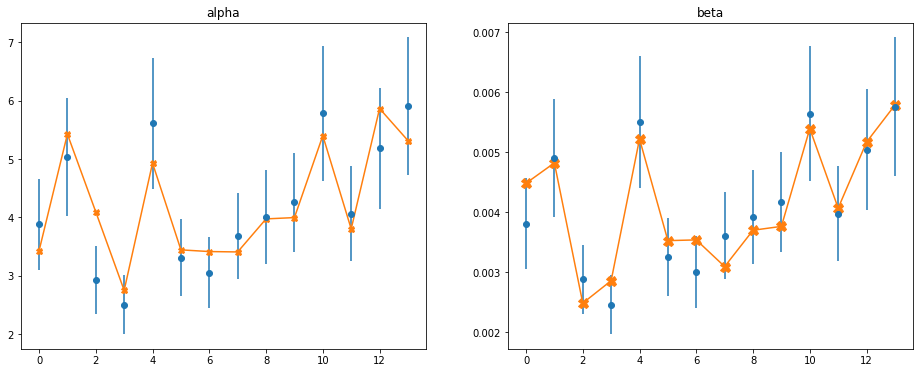

In [42]:
df_input['alpha_0'] = results_from_regr_alpha0
df_input['beta_0'] = results_from_regr_beta0
# error bar plot of Nu
fig, axs = plt.subplots(1,2, figsize = (16,6))

axs[0].errorbar(df_input.reset_index().index, df_input.reset_index()['alpha'], df_input.reset_index()['alpha']*0.2, fmt = 'o')
axs[0].plot(df_input.reset_index().index, df_input.reset_index()['alpha_0'], marker = 'X')
axs[0].set_title('alpha')

axs[1].errorbar(df_input.reset_index().index, df_input.reset_index()['beta'], df_input.reset_index()['beta']*0.2, fmt = 'o')
axs[1].plot(df_input.reset_index().index, df_input.reset_index()['beta_0'], marker = 'X', markersize = 10)
axs[1].set_title('beta')

## Dempav with corrected contact area

Nu

In [48]:
df_input = generate_regression_input(os.path.join(path_sim_output, 'final_output_dempav_corr_a.csv'), if_log = False)

number of cooling datapoint is 17 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


In [49]:
df_input = df_input.query('Nu>1')

In [61]:
# without considering uncertainty,  p0=[1,1,1,1,1,1]
popt_Nu0, pcov_Nu0 = regr_via_scipy(df=df_input, target="Nu", sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

results_from_regr_Nu0 = func_Nu(df_input, *popt_Nu0)
calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu0)

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.29511254464375314

In [62]:
popt_Nu0

array([ 0.30383404,  0.55030407, -6.57760003,  0.27777284, -0.35543665,
        0.        ])

Sh

In [57]:
popt_Sh0, pcov_Sh0 = regr_via_scipy(df=df_input, target='Sh', sigma_ratio=None, abs_sigma=True, iter_num=100000)
results_from_regr_Sh0 = func_Sh(df_input, *popt_Sh0)
calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh0)

0.7643890403073701

In [58]:
popt_Sh0

array([ 1.65472047e-48,  2.10755949e+00, -2.29954817e+02,  1.54627474e+00,
       -2.46252927e-01, -4.59658958e-01])

In [59]:
df_input_analysis = pd.concat([df_input['m_d_in']/df_input['m_a_in'], df_input['T_d_in']/df_input['T_a_in'], 1-df_input['x_d_in_equ']/df_input['x_a_in'], \
                               df_input['Re']/2300, df_input['Pr'], df_input['Sc']], axis=1, \
                              keys=['ratio_m', 'ratio_T', 'ratio_x', 'Re', 'Pr', 'Sc'])

Text(0.5, 1.0, 'Sh')

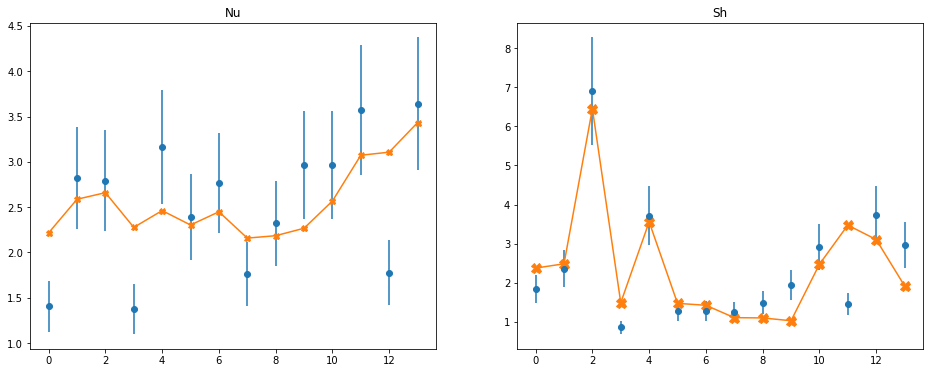

In [63]:
df_input['Nu_0'] = results_from_regr_Nu0
df_input['Sh_0'] = results_from_regr_Sh0
# error bar plot of Nu
fig, axs = plt.subplots(1,2, figsize = (16,6))

axs[0].errorbar(df_input.reset_index().index, df_input.reset_index()['Nu'], df_input.reset_index()['Nu']*0.2, fmt = 'o')
axs[0].plot(df_input.reset_index().index, df_input.reset_index()['Nu_0'], marker = 'X')
axs[0].set_title('Nu')

axs[1].errorbar(df_input.reset_index().index, df_input.reset_index()['Sh'], df_input.reset_index()['Sh']*0.2, fmt = 'o')
axs[1].plot(df_input.reset_index().index, df_input.reset_index()['Sh_0'], marker = 'X', markersize = 10)
axs[1].set_title('Sh')

## check regression ZHAW DATA Muhannad

In [64]:
df_input = generate_regression_input(os.path.join(path_sim_output, 'ZHAW_DATA.csv'), if_log=False, )

number of cooling datapoint is 17 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


**Nu**

In [65]:
# without considering uncertainty
popt_Nu0, pcov_Nu0 = regr_via_scipy(df=df_input, target='Nu', sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [66]:
popt_Nu0

array([11.84516994,  0.88112483,  0.14138304, -0.89623371, -1.66365664,
        0.        ])

In [67]:
results_from_regr_Nu0 = func_Nu(df_input, *popt_Nu0)
calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu0)

0.7403248493018602

In [68]:
# with considering uncertainty
popt_Nu1, pcov_Nu1 = regr_via_scipy(df=df_input, target='Nu', sigma_ratio=0.2, abs_sigma=True, iter_num=20000, method='lm')

In [69]:
popt_Nu1

array([105.84979227,   1.4789868 ,   7.08969679,  -1.07200016,
        -2.09130253,   0.        ])

In [70]:
results_from_regr_Nu1 = func_Nu(df_input, *popt_Nu1)
calc_R_squared(data_ref=df_input['Nu'], data_cal=results_from_regr_Nu1)

0.6802363673861895

In [71]:
df_input['Nu_0'] = results_from_regr_Nu0
df_input['Nu_1'] = results_from_regr_Nu1

**Sh**

In [72]:
# without uncertainty
popt_Sh0, pcov_Sh0 = regr_via_scipy(df=df_input, target='Sh', sigma_ratio=None, abs_sigma=True, iter_num=100000)
results_from_regr_Sh0 = func_Sh(df_input, *popt_Sh0)
calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh0)

0.5305734987132409

In [73]:
# with uncertainty = 0.2 Sh
popt_Sh1, pcov_Sh1 = regr_via_scipy(df=df_input, target='Sh', sigma_ratio=0.2, abs_sigma=True, iter_num=100000)
results_from_regr_Sh1 = func_Sh(df_input, *popt_Sh1)
calc_R_squared(data_ref=df_input['Sh'], data_cal=results_from_regr_Sh1)

0.441306572690769

In [74]:
df_input['Sh_0'] = results_from_regr_Sh0
df_input['Sh_1'] = results_from_regr_Sh1

In [46]:
# df_input.to_csv('regression_chen.csv')

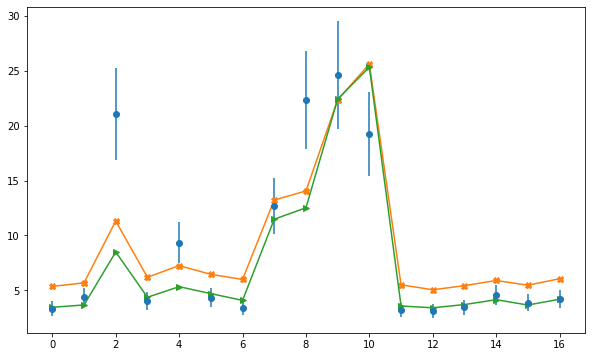

In [75]:
# error bar plot of Nu
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_input.reset_index().index, df_input.reset_index()['Nu'], df_input.reset_index()['Nu']*0.2, fmt = 'o')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Nu_0'], marker = 'X')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Nu_1'], marker = '>')

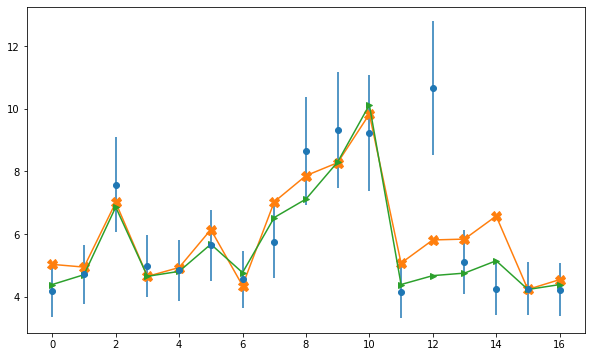

In [76]:
# error bar plot of Sh
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_input.reset_index().index, df_input.reset_index()['Sh'], df_input.reset_index()['Sh']*0.2, fmt = 'o')
ax.plot(df_input.reset_index().index, df_input.reset_index()['Sh_0'], marker = 'X', markersize = 10)
ax.plot(df_input.reset_index().index, df_input.reset_index()['Sh_1'], marker = '>')

# compare outlet parameter calculated using different approaches 
(formula, logm, iteration+regression)

In [5]:
# data_path = os.path.join(os.path.expanduser('~'), 'git', 'EnBA_M', 'BrineGrid_HDisNet')

## Chen LiCl

In [77]:
path_chen = os.path.join(os.path.expanduser("~"), "GIT", "TheGreeFa_EnBA", "Data_input", )

In [78]:
# Exp data & Chen-Formular
df_exp = pd.read_excel(os.path.join(path_chen, "measurement", "actual_data_converted", "Chen2016.xlsx"),index_col=0)

In [79]:
# Iteration data
df_iter = pd.read_csv(os.path.join(path_sim_output, 'final_output_iter_NuSh.csv'),index_col=0)

In [81]:
# log mean calculated Nu and Sh
df_logm = pd.read_csv(os.path.join(path_sim_output, 'final_output_logm.csv'),index_col=0)

In [83]:
df_compare = df_exp.copy()

In [84]:
xi_d_o_sim = np.array([0.228899136, 0.238542348, 0.253555626, 0.258651882, 0.268602729, 0.250440776, \
                        0.258630842, 0.268650621, 0.283595651, 0.294590622, 0.299044311, 0.303684443, \
                        0.316650063, 0.319703698, 0.329579026])

df_compare['xi_d_o_sim'] = xi_d_o_sim

df_compare['T_a_o_iter'] = df_iter['T_a_o_sim_reg']
df_compare['x_a_o_iter'] = df_iter['x_a_o_sim_reg']
df_compare['T_d_o_iter'] = df_iter['T_d_o_sim_reg']
df_compare['xi_d_o_iter'] = df_iter['xi_d_o_sim_reg']

In [85]:
df_compare['T_a_o_logm'] = df_logm['T_a_o_sim_reg']
df_compare['x_a_o_logm'] = df_logm['x_a_o_sim_reg']
df_compare['T_d_o_logm'] = df_logm['T_d_o_sim_reg']
df_compare['xi_d_o_logm'] = df_logm['xi_d_o_sim_reg']

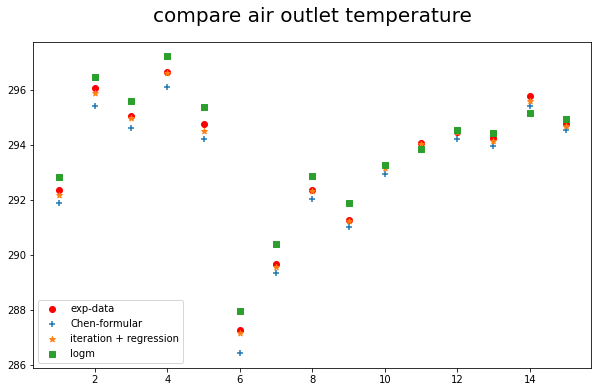

In [86]:
fig, ax = plt.subplots(figsize = (10,6))

x = df_compare.index
ax.scatter(x, df_compare.T_a_o_exp.to_numpy(), marker = 'o', color = 'red', label = 'exp-data')
ax.scatter(x, df_compare.T_a_o_sim.to_numpy(), marker = '+', label = 'Chen-formular')
ax.scatter(x, df_compare.T_a_o_iter.to_numpy(), marker = '*', label = 'iteration + regression')
ax.scatter(x, df_compare.T_a_o_logm.to_numpy(), marker = 's', label = 'logm')

ax.set_title('compare air outlet temperature', fontsize = 20, pad = 20)
ax.legend()

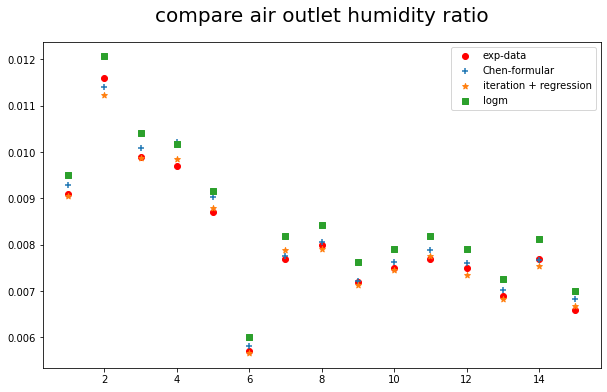

In [87]:
fig, ax = plt.subplots(figsize = (10,6))

x = df_compare.index
ax.scatter(x, df_compare.x_a_o_exp.to_numpy(), marker = 'o', color = 'red', label = 'exp-data')
ax.scatter(x, df_compare.x_a_o_sim.to_numpy()/1000
           , marker = '+', label = 'Chen-formular')
ax.scatter(x, df_compare.x_a_o_iter.to_numpy(), marker = '*', label = 'iteration + regression')
ax.scatter(x, df_compare.x_a_o_logm.to_numpy(), marker = 's', label = 'logm')

ax.set_title('compare air outlet humidity ratio', fontsize = 20, pad = 20)
ax.legend()

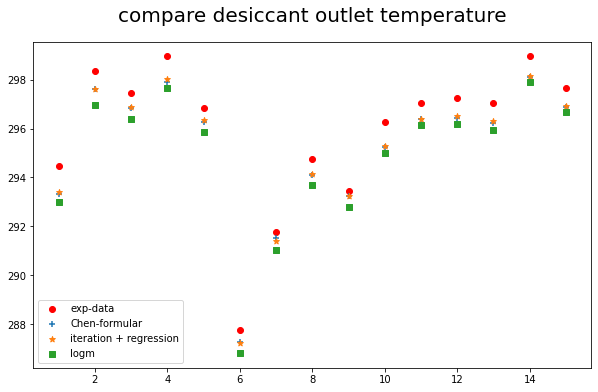

In [88]:
fig, ax = plt.subplots(figsize = (10,6))

x = df_compare.index
ax.scatter(x, df_compare.T_d_o_exp .to_numpy(), marker = 'o', color = 'red', label = 'exp-data')
ax.scatter(x, df_compare.T_d_o_sim.to_numpy()+273.15, marker = '+', label = 'Chen-formular')
ax.scatter(x, df_compare.T_d_o_iter.to_numpy(), marker = '*', label = 'iteration + regression')
ax.scatter(x, df_compare.T_d_o_logm.to_numpy(), marker = 's', label = 'logm')

ax.set_title('compare desiccant outlet temperature', fontsize = 20, pad = 20)

ax.legend()

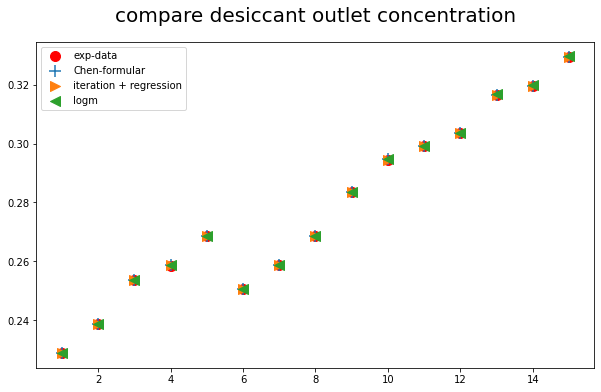

In [89]:
fig, ax = plt.subplots(figsize = (10,6))

x = df_compare.index
ax.scatter(x, df_compare.xi_d_o_exp .to_numpy(), marker = 'o', s = 100, color = 'red', label = 'exp-data')
ax.scatter(x, df_compare.xi_d_o_sim.to_numpy(), marker = '+', s = 150, label = 'Chen-formular')
ax.scatter(x, df_compare.xi_d_o_iter.to_numpy(), marker = '>', s = 100, label = 'iteration + regression')
ax.scatter(x, df_compare.xi_d_o_logm.to_numpy(), marker = '<', s = 100, label = 'logm')

ax.set_title('compare desiccant outlet concentration', fontsize = 20, pad = 20)
ax.legend()

# New data dempav 2021 regression

## cooling & dehumidification

In [9]:
df_dempav2021_cooling = generate_regression_input('./table_for_regression/final_output_dempav2021_cooling.csv', if_log=False, )

number of cooling datapoint is 16 

following datasets are excluded from regression: 
 set().
no Nu_2 and Sh_2 in dataframe.
###### use unsorted calibration data ######


In [44]:
df_dempav2021_cooling.head(2)

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,x_d_in_equ,m_d_in,T_a_o_exp,T_d_o_exp,x_a_o_exp,Re,Pr,Sc,Nu,Sh,Nu_0,Nu_1,Sh_0,Sh_1
23,298.02,0.009457,0.018848,287.44,0.318302,0.004515,0.10267,290.21,286.230,0.005773,665.090372,0.716941,0.616288,8.071432,7.099632,7.434575,4.712128,8.094985,8.743690
24,300.51,0.012683,0.036283,292.20,0.318186,0.006170,0.10267,294.81,290.092,0.008716,1274.153030,0.719955,0.616900,13.659604,11.556247,13.208149,13.590911,12.190072,9.380738


In [56]:
# without considering uncertainty
popt_Nu0, pcov_Nu0 = regr_via_scipy(df=df_dempav2021_cooling, target='Nu', sigma_ratio=None, abs_sigma=True, iter_num=20000, method='lm')

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [57]:
popt_Nu0

array([ 1.07936242e+09,  4.78211721e-01,  5.55048224e+01, -1.31861572e-01,
       -6.60670392e-01,  0.00000000e+00])

In [59]:
results_from_regr_Nu0 = func_Nu(df_dempav2021_cooling, *popt_Nu0)
calc_R_squared(data_ref=df_dempav2021_cooling['Nu'], data_cal=results_from_regr_Nu0)

0.470882221960096

In [60]:
# with considering uncertainty
popt_Nu1, pcov_Nu1 = regr_via_scipy(df=df_dempav2021_cooling, target='Nu', sigma_ratio=0.2, abs_sigma=True, iter_num=20000, method='lm')

In [52]:
popt_Nu1

array([ 4.41371254e+22,  1.46151883e-01,  1.50372031e+02, -6.31724149e-01,
       -9.27745917e-01,  1.00000000e+00])

In [41]:
results_from_regr_Nu1 = func_Nu(df_dempav2021_cooling, *popt_Nu1)
calc_R_squared(data_ref=df_dempav2021_cooling['Nu'], data_cal=results_from_regr_Nu1)

0.12311249186552997

In [53]:
df_dempav2021_cooling['Nu_0'] = results_from_regr_Nu0
df_dempav2021_cooling['Nu_1'] = results_from_regr_Nu1

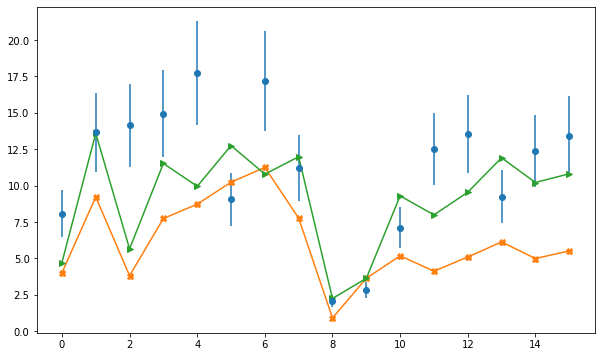

In [61]:
# error bar plot of Nu
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_dempav2021_cooling.reset_index().index, df_dempav2021_cooling.reset_index()['Nu'], df_dempav2021_cooling.reset_index()['Nu']*0.2, fmt = 'o')
ax.plot(df_dempav2021_cooling.reset_index().index, df_dempav2021_cooling.reset_index()['Nu_0'], marker = 'X')
ax.plot(df_dempav2021_cooling.reset_index().index, df_dempav2021_cooling.reset_index()['Nu_1'], marker = '>')

**Sh**

In [24]:
# without uncertainty
popt_Sh0, pcov_Sh0 = regr_via_scipy(df=df_dempav2021_cooling, target='Sh', sigma_ratio=None, abs_sigma=True, iter_num=20000)
results_from_regr_Sh0 = func_Sh(df_dempav2021_cooling, *popt_Sh0)
calc_R_squared(data_ref=df_dempav2021_cooling['Sh'], data_cal=results_from_regr_Sh0)

0.3752982665038346

In [25]:
# with uncertainty = 0.2 Sh
popt_Sh1, pcov_Sh1 = regr_via_scipy(df=df_dempav2021_cooling, target='Sh', sigma_ratio=0.2, abs_sigma=True, iter_num=50000)
results_from_regr_Sh1 = func_Sh(df_dempav2021_cooling, *popt_Sh1)
calc_R_squared(data_ref=df_dempav2021_cooling['Sh'], data_cal=results_from_regr_Sh1)

-0.38879397436998353

In [26]:
df_dempav2021_cooling['Sh_0'] = results_from_regr_Sh0
df_dempav2021_cooling['Sh_1'] = results_from_regr_Sh1

In [46]:
# df_input.to_csv('regression_chen.csv')

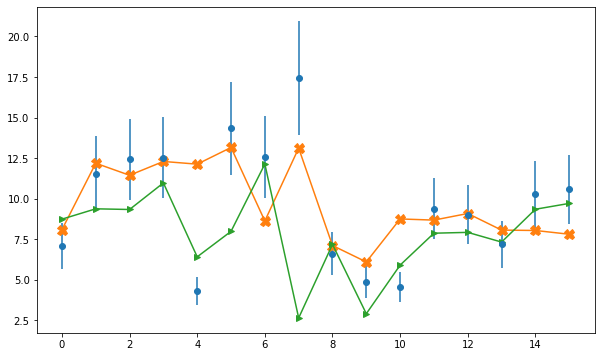

In [29]:
# error bar plot of Sh
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(df_dempav2021_cooling.reset_index().index, df_dempav2021_cooling.reset_index()['Sh'], df_dempav2021_cooling.reset_index()['Sh']*0.2, fmt = 'o')
ax.plot(df_dempav2021_cooling.reset_index().index, df_dempav2021_cooling.reset_index()['Sh_0'], marker = 'X', markersize = 10)
ax.plot(df_dempav2021_cooling.reset_index().index, df_dempav2021_cooling.reset_index()['Sh_1'], marker = '>')

# code archiv (regression)

In [5]:
obj_regression = pp.EnBA_M_post_processing(folder_name = "Okt_1_teststand", file_name = "final_output.csv")

In [33]:
df = obj_regression.generate_regression_input(sorted_by="N", if_log=False)

###### use unsorted calibration data ######


.\..\calibration\postprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_selected['log_Re'] = df_input_selected['Re'].apply(math.log)
.\..\calibration\postprocessing.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_selected['log_Pr'] = df_input_selected['Pr'].apply(math.log)
.\..\calibration\postprocessing.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

########### data selected for training are: ############ 
     T_a_in    x_a_in    m_a_in  T_d_in  x_d_in_equ    m_d_in          Re  \
17  312.47  0.014462  0.024743  286.62    0.004720  0.031900  865.404064   
16  314.19  0.015769  0.017850  284.92    0.004096  0.030950  622.153195   
25  307.97  0.018384  0.025909  283.36    0.003791  0.025748  918.043959   
15  315.48  0.017856  0.010222  283.15    0.003558  0.029746  355.574299   
24  309.90  0.021434  0.020414  284.00    0.003884  0.025600  721.059910   
18  312.94  0.018147  0.015962  280.02    0.002842  0.017361  558.726932   
21  314.95  0.022082  0.015434  279.72    0.002970  0.018040  538.750049   
23  312.81  0.023688  0.016475  283.18    0.003502  0.021037  578.515857   
19  319.85  0.024894  0.010045  278.88    0.002593  0.017147  347.120652   
28  314.89  0.024553  0.014786  283.01    0.003566  0.008974  516.868044   
27  312.35  0.024478  0.018216  284.34    0.003709  0.007967  640.617911   
22  315.72  0.030577  0.01098

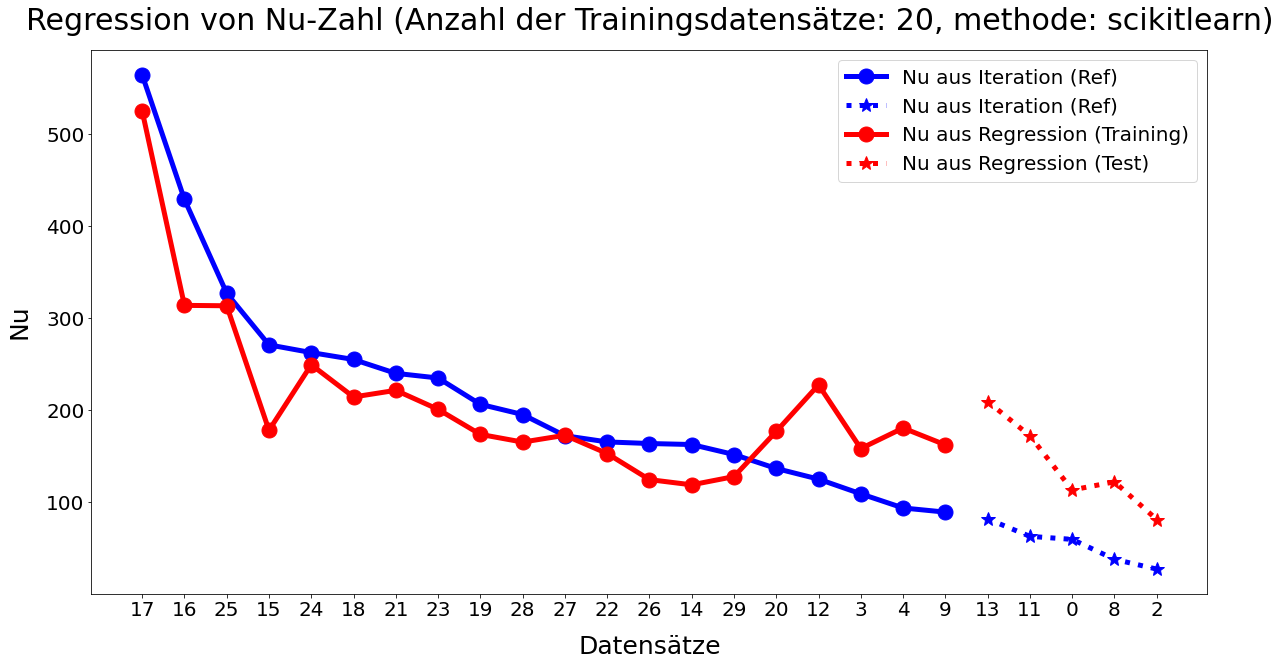

In [29]:
df_compare = obj_regression.run_regression_and_compare(target="Nu", sorted=True, \
                                                       method="scikitlearn", num_training=20, \
                                                       num_max_iter=20000, if_plot=True)

In [32]:
df_compare.set_index("index_ori", inplace=True)
df_compare

,simulation,regression
index_ori,,
17,564.443317,525.246919
16,429.121216,313.948875
25,327.131418,313.517662
15,271.021495,178.184312
24,262.647438,249.412703
18,255.132225,214.386744
21,240.067542,221.616122
23,235.002338,200.922694
19,206.396586,173.726530


In [42]:
df.drop([])

,T_a_in,x_a_in,m_a_in,T_d_in,x_d_in_equ,m_d_in,Re,Pr,Sc,Nu,Sh,test
24,309.90,0.021434,0.020414,284.00,0.003884,0.025600,721.059910,0.727922,0.618673,262.647438,282.968004,249.412703
13,299.00,0.015512,0.016035,283.23,0.003822,0.015725,580.275548,0.723075,0.616832,81.859932,305.388533,209.462815
2,300.89,0.021207,0.006098,280.90,0.002928,0.012293,220.212335,0.728775,0.617446,27.307056,167.180888,81.192118
0,304.36,0.026531,0.006077,278.89,0.002680,0.023112,218.115697,0.733928,0.618186,59.617640,149.687222,113.301040
12,299.89,0.015631,0.016031,284.13,0.003914,0.025426,578.867513,0.723086,0.616977,125.088085,332.010742,227.537746
26,313.12,0.023017,0.011307,282.58,0.003047,0.009135,396.620106,0.729207,0.619127,163.795572,126.949465,124.556505
25,307.97,0.018384,0.025909,283.36,0.003791,0.025748,918.043959,0.724968,0.618294,327.131418,351.041390,313.517662
3,300.63,0.015496,0.013109,280.34,0.002929,0.012012,472.435895,0.722853,0.617083,109.106587,248.968735,158.315363
16,314.19,0.015769,0.017850,284.92,0.004096,0.030950,622.153195,0.721552,0.619034,429.121216,178.972156,313.948875
19,319.85,0.024894,0.010045,278.88,0.002593,0.017147,347.120652,0.730441,0.619937,206.396586,111.347215,173.726530


In [35]:
df["test"] = df_compare["regression"]

In [36]:
df

,T_a_in,x_a_in,m_a_in,T_d_in,x_d_in_equ,m_d_in,Re,Pr,Sc,Nu,Sh,test
24,309.90,0.021434,0.020414,284.00,0.003884,0.025600,721.059910,0.727922,0.618673,262.647438,282.968004,249.412703
13,299.00,0.015512,0.016035,283.23,0.003822,0.015725,580.275548,0.723075,0.616832,81.859932,305.388533,209.462815
2,300.89,0.021207,0.006098,280.90,0.002928,0.012293,220.212335,0.728775,0.617446,27.307056,167.180888,81.192118
0,304.36,0.026531,0.006077,278.89,0.002680,0.023112,218.115697,0.733928,0.618186,59.617640,149.687222,113.301040
12,299.89,0.015631,0.016031,284.13,0.003914,0.025426,578.867513,0.723086,0.616977,125.088085,332.010742,227.537746
26,313.12,0.023017,0.011307,282.58,0.003047,0.009135,396.620106,0.729207,0.619127,163.795572,126.949465,124.556505
25,307.97,0.018384,0.025909,283.36,0.003791,0.025748,918.043959,0.724968,0.618294,327.131418,351.041390,313.517662
3,300.63,0.015496,0.013109,280.34,0.002929,0.012012,472.435895,0.722853,0.617083,109.106587,248.968735,158.315363
16,314.19,0.015769,0.017850,284.92,0.004096,0.030950,622.153195,0.721552,0.619034,429.121216,178.972156,313.948875
19,319.85,0.024894,0.010045,278.88,0.002593,0.017147,347.120652,0.730441,0.619937,206.396586,111.347215,173.726530


In [37]:
df_compare

,simulation,regression
index_ori,,
17,564.443317,525.246919
16,429.121216,313.948875
25,327.131418,313.517662
15,271.021495,178.184312
24,262.647438,249.412703
18,255.132225,214.386744
21,240.067542,221.616122
23,235.002338,200.922694
19,206.396586,173.726530


In [21]:
df.shape

(25, 12)

### Validate calculation of Nu & Sh

In [225]:
mu = HAPropsSI('mu', 'T', 298.75, 'P', 101325, 'W', 0.0162)

In [20]:
bib_path = os.path.join(os.path.expanduser("~"),"GIT","EnBA_M","BrineGrid_HDisNet")
model_name_LiCl = "Aug_23_2020_Calibration_Chen_2016"
model_name_Mg = "Aug_23_2020_Calibration_MgCl2"
output_path_Li = os.path.join(bib_path, 'modelica_results', model_name_LiCl)
output_path_Mg = os.path.join(bib_path, 'modelica_results', model_name_Mg)

In [21]:
output_path_Li

'C:\\Users\\guwang\\GIT\\EnBA_M\\BrineGrid_HDisNet\\modelica_results\\Aug_23_2020_Calibration_Chen_2016'

In [22]:
df_Li = pd.read_csv(filepath_or_buffer=output_path_Li+'\\final_output.csv').drop(columns = ["Unnamed: 0"])
df_Li_select_cool = df_Li[df_Li.T_a_in - df_Li.T_a_o_exp >1]
df_Li_select_cool

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,T_d_o_sim,...,x_a_o_sim,Nu,Sh,T_a_o_sim_new,x_a_o_sim_new,xi_d_out,x_d_in_equ,Re,Pr,Sc
0,298.75,0.0162,1.85,288.05,0.2300,2.61,292.35,0.0091,294.45,20.19,...,9.29,3.221012,3.255806,292.457184,0.009092,0.228848,0.007228,897.028878,0.723822,0.616835
1,301.75,0.0202,1.87,291.35,0.2400,2.63,296.05,0.0116,298.35,24.45,...,11.41,3.146775,1.965057,295.896729,0.012749,0.238541,0.008621,901.585670,0.727614,0.617514
2,297.35,0.0160,1.98,290.85,0.3007,2.85,294.05,0.0077,297.05,23.22,...,7.88,4.421589,2.340150,292.651276,0.006107,0.298976,0.006254,963.424599,0.723793,0.616603
3,298.25,0.0152,1.94,291.25,0.3052,2.90,294.45,0.0075,297.25,23.27,...,7.61,4.399534,3.821553,294.417114,0.007286,0.303636,0.006259,941.424700,0.722846,0.616694
4,298.35,0.0143,1.95,290.95,0.3182,2.85,294.25,0.0069,297.05,23.08,...,7.02,4.682485,3.722464,294.138702,0.006704,0.316597,0.005690,945.628679,0.721900,0.616654
5,298.75,0.0143,1.93,291.55,0.3312,2.88,294.75,0.0066,297.65,23.72,...,6.84,4.925661,3.725612,294.657288,0.006421,0.329500,0.005458,934.970118,0.721849,0.616717
6,300.65,0.0181,1.92,290.85,0.2550,2.65,295.05,0.0099,297.45,23.69,...,10.08,3.753491,4.059564,294.904022,0.010961,0.253494,0.007838,927.325325,0.725560,0.617236
7,303.15,0.0177,1.89,292.05,0.2600,2.66,296.65,0.0097,298.95,24.74,...,10.22,3.223474,3.906512,296.837738,0.009668,0.258530,0.008284,906.929631,0.724833,0.617582
8,300.75,0.0164,1.92,290.45,0.2700,2.67,294.75,0.0087,296.85,23.10,...,9.03,3.553587,3.610193,294.830048,0.008668,0.268513,0.007133,926.330979,0.723778,0.617154
9,294.85,0.0108,2.04,282.65,0.2513,2.93,287.25,0.0057,287.75,14.13,...,5.81,3.224658,3.748884,287.394714,0.005689,0.250411,0.004611,996.633523,0.718731,0.615837


In [24]:
df_Mg = pd.read_csv(filepath_or_buffer=output_path_Mg+'\\final_output.csv').drop(columns = ["Unnamed: 0"])
df_Mg_select_cool = df_Mg[df_Mg.T_a_in - df_Mg.T_a_o_exp >1]

In [25]:
df_Li_reg = df_Li_select_cool[['T_a_in', 'x_a_in', 'm_a_in', \
                    'T_d_in', 'x_d_in_equ', 'm_d_in', \
                    'Re', 'Pr', 'Sc',\
                    'Nu', 'Sh']]
df_Mg_reg = df_Mg_select_cool[['T_a_in', 'x_a_in', 'm_a_in', \
                    'T_d_in', 'x_d_in_equ', 'm_d_in', \
                    'Re', 'Pr', 'Sc',\
                    'Nu', 'Sh']]

## define Nu and Sh reference function

In [33]:
def func_Nu(variables, a, b, c, d, e, f):
    Re = variables['Re'].to_numpy()
    Pr = variables['Pr'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()
    
    Nu = a * np.power(Re, b) * np.power(Pr, c) * np.power((m_d/m_a), d) * \
    np.power((1-w_d/w_a), e) * np.power((T_d-273.15/T_a-273.15), f)
    
    return Nu

In [34]:
def func_Sh(variables, a, b, c, d, e, f):
    Re = variables['Re'].to_numpy()
    Sc = variables['Sc'].to_numpy()
    m_d = variables['m_d_in'].to_numpy()
    m_a = variables['m_a_in'].to_numpy()
    w_d = variables['x_d_in_equ'].to_numpy()
    w_a = variables['x_a_in'].to_numpy()
    T_d = variables['T_d_in'].to_numpy()
    T_a = variables['T_a_in'].to_numpy()
    
    Sh = a * np.power(Re, b) * np.power(Sc, c) * np.power((m_d/m_a), d) * \
    np.power((1-w_d/w_a), e) * np.power((T_d-273.15/T_a-273.15), f)
    
    return Sh

## Regression with Scipy

In [35]:
def regress_Nu(df, p0 = [200, 1.5, 1/3, -1, 0.8, 0.4], iter_num = 2000, method = "scipy"):
    if method == 'scipy':
        results = optimize.curve_fit(func_Nu, df, df.Nu.to_numpy(), p0=p0, maxfev = iter_num)
    return results[0]

In [36]:
def regress_Sh(df, p0 = [200, 1.5, 1/3, -1, 0.8, 0.4], iter_num = 2000, method = "scipy"):
    if method == 'scipy':
        results = optimize.curve_fit(func_Sh, df, df.Sh.to_numpy(), p0=p0, maxfev = iter_num)
    return results[0]

### Nu_LiCl

In [53]:
df_Li_reg_plot = df_Li_reg.copy()
df_Li_reg_plot["index_ori"] = df_Li_reg_plot.index
df_Li_reg_plot.sort_values(by="Nu", inplace = True)
# df_Li_reg_plot.reset_index()

In [54]:
df_Li_reg_plot

,T_a_in,x_a_in,m_a_in,T_d_in,x_d_in_equ,m_d_in,Re,Pr,Sc,Nu,Sh,index_ori
1,301.75,0.0202,1.87,291.35,0.008621,2.63,901.585670,0.727614,0.617514,3.146775,1.965057,1
0,298.75,0.0162,1.85,288.05,0.007228,2.61,897.028878,0.723822,0.616835,3.221012,3.255806,0
7,303.15,0.0177,1.89,292.05,0.008284,2.66,906.929631,0.724833,0.617582,3.223474,3.906512,7
9,294.85,0.0108,2.04,282.65,0.004611,2.93,996.633523,0.718731,0.615837,3.224658,3.748884,9
8,300.75,0.0164,1.92,290.45,0.007133,2.67,926.330979,0.723778,0.617154,3.553587,3.610193,8
6,300.65,0.0181,1.92,290.85,0.007838,2.65,927.325325,0.725560,0.617236,3.753491,4.059564,6
10,295.85,0.0153,1.97,285.75,0.005477,2.76,961.960250,0.723260,0.616317,4.031071,2.607975,10
11,297.85,0.0153,1.96,288.65,0.006341,2.77,952.152522,0.723001,0.616637,4.328940,3.421112,11
3,298.25,0.0152,1.94,291.25,0.006259,2.90,941.424700,0.722846,0.616694,4.399534,3.821553,3
2,297.35,0.0160,1.98,290.85,0.006254,2.85,963.424599,0.723793,0.616603,4.421589,2.340150,2


In [61]:
[str(i) for i in df_compare_Nu.index_ori]

['1', '0', '7', '9', '8', '6', '10', '11', '3', '2', '4', '12', '5', '13']

In [69]:
df_compare_Nu

,real,sim,index_ori
0,3.146775,3.267052,1
1,3.221012,3.122676,0
2,3.223474,3.319402,7
3,3.224658,3.324858,9
4,3.553587,3.777475,8
5,3.753491,3.578297,6
6,4.031071,4.065011,10
7,4.328940,3.948052,11
8,4.399534,4.313680,3
9,4.421589,4.538066,2


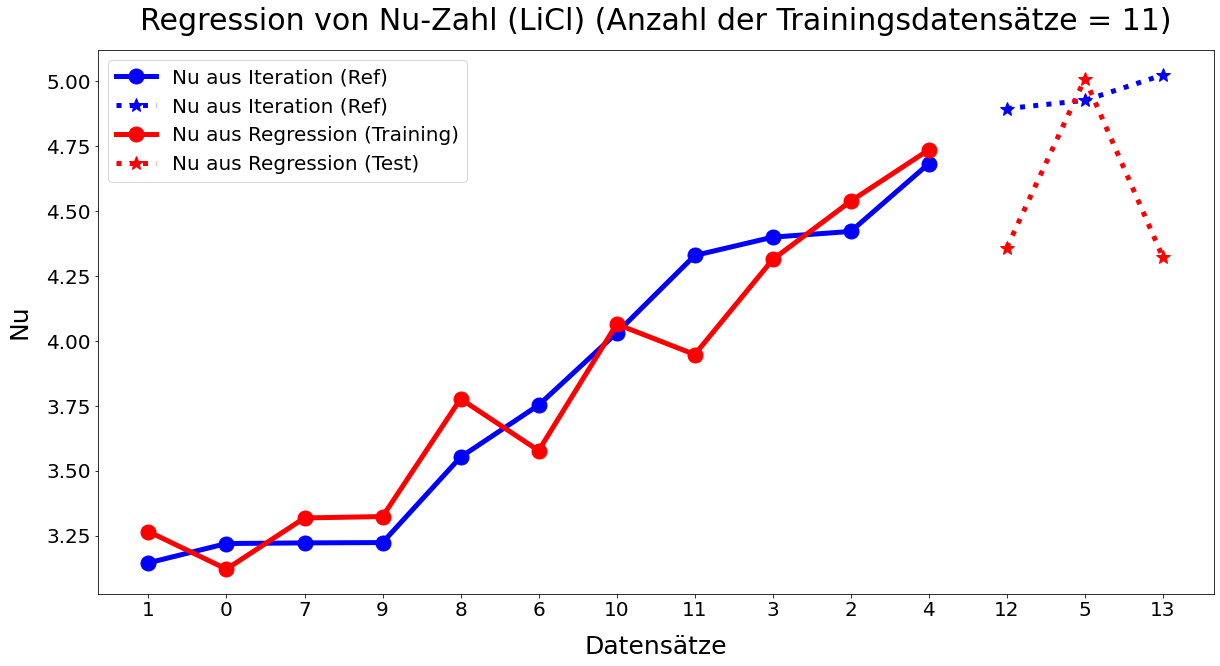

In [68]:
num_train = 11

Nu_Li_15 = regress_Nu(df_Li_reg_plot.head(num_train), iter_num=100000)

Nu_Li_sim = func_Nu(df_Li_reg_plot, Nu_Li_15[0], Nu_Li_15[1],\
       Nu_Li_15[2], Nu_Li_15[3],\
       Nu_Li_15[4], Nu_Li_15[5])

df_compare_Nu = pd.DataFrame(list(zip(df_Li_reg_plot.Nu, Nu_Li_sim)), \
                             columns=['real', 'sim'])
df_compare_Nu["index_ori"] = df_Li_reg_plot.index

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_compare_Nu.real[0:num_train], color = 'blue',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.real[num_train:], color = 'blue',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.sim[0:num_train], color = 'red',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Regression (Training)')
ax.plot(df_compare_Nu.sim[num_train:], color = 'red',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Regression (Test)')

ax.tick_params(labelsize = 20)

ax.set_xlabel("Datensätze", size = 25, labelpad = 15)
ax.set_ylabel("Nu", size = 25, labelpad = 15)

ax.set_title('Regression von Nu-Zahl (LiCl) (Anzahl der Trainingsdatensätze = {})'.format(num_train), size = 30, pad = 20)

plt.xticks(df_compare_Nu.index,[str(i) for i in df_compare_Nu.index_ori])
plt.legend(loc = "upper left",fontsize = 20)
# plt.savefig("./bilder/Li_Nu_{}.png".format(num_train), dpi = 300, tranparent=True)

### Sh_LiCl

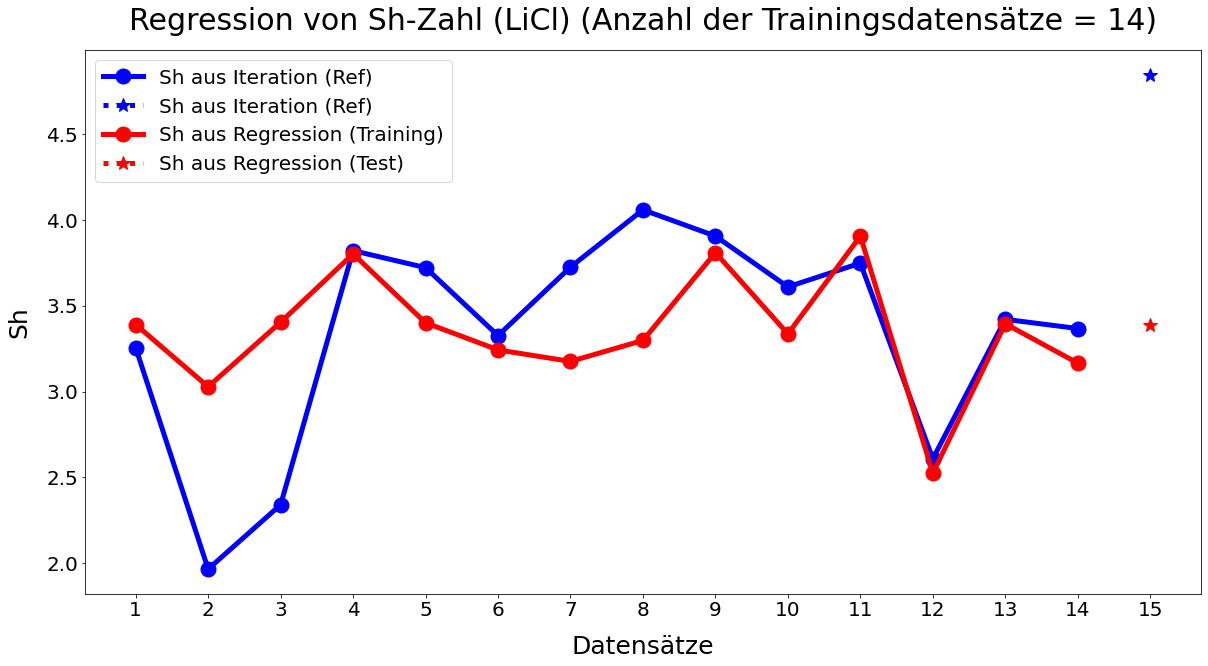

In [70]:
num_train = 14

Sh_Li_15 = regress_Sh(df_Li_reg.head(num_train), iter_num=50000)

Sh_Li_sim = func_Sh(df_Li_reg, Sh_Li_15[0], Sh_Li_15[1],\
       Sh_Li_15[2], Sh_Li_15[3],\
       Sh_Li_15[4], Sh_Li_15[5])

df_compare_Sh = pd.DataFrame(list(zip(df_Li_reg.Sh, Sh_Li_sim)), \
                             columns=['real', 'sim'])
df_compare_Sh.index = df_compare_Sh.index+1

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_compare_Sh.real[0:num_train], color = 'blue',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Sh aus Iteration (Ref)')
ax.plot(df_compare_Sh.real[num_train:], color = 'blue',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Sh aus Iteration (Ref)')
ax.plot(df_compare_Sh.sim[0:num_train], color = 'red',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Sh aus Regression (Training)')
ax.plot(df_compare_Sh.sim[num_train:], color = 'red',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Sh aus Regression (Test)')

ax.tick_params(labelsize = 20)

ax.set_xticks(np.arange(1,16))
ax.set_xlabel("Datensätze", size = 25, labelpad = 15)
ax.set_ylabel("Sh", size = 25, labelpad = 15)

ax.set_title('Regression von Sh-Zahl (LiCl) (Anzahl der Trainingsdatensätze = {})'.format(num_train), size = 30, pad = 20)


plt.legend(loc = "upper left",fontsize = 20)
# plt.savefig("./bilder/Li_Sh_{}.png".format(num_train), dpi = 300, tranparent=True)

### Mg_Nu

In [153]:
df_Mg_select_cool.iloc[:5,:]

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,w_air_in,...,x_a_o_exp,Nu,Sh,T_a_o_sim_new,x_a_o_sim_new,xi_d_out,x_d_in_equ,Re,Pr,Sc
6,290.31,52.20,0.018728,276.01,0.277934,0.104689,285.55,39.03,275.225,0.006324,...,0.003469,191.061995,516.598004,285.686127,0.003817,0.277792,0.002552,4596.168552,0.714750,0.614671
7,291.66,47.59,0.018106,282.41,0.276896,0.104689,287.64,47.07,281.917,0.006277,...,0.004805,253.548841,400.798614,287.824341,0.004946,0.276824,0.004029,4427.450462,0.714521,0.614921
18,302.39,49.11,0.050221,293.32,0.318283,0.102676,300.51,42.09,291.612,0.012474,...,0.009558,307.719380,733.229943,300.565826,0.009753,0.317826,0.006625,11978.093519,0.719532,0.617187
8,297.19,42.33,0.043522,284.42,0.323335,0.049907,292.08,47.65,281.459,0.007858,...,0.006467,646.207204,422.315072,292.116364,0.006472,0.322939,0.003572,10496.096648,0.715421,0.616040
2,290.56,73.96,0.046145,288.03,0.276610,0.104692,289.51,60.06,286.984,0.009144,...,0.006936,705.543257,1100.355742,289.607880,0.007180,0.276339,0.005896,11331.652622,0.717612,0.614949


In [140]:
df_Mg_select_cool.sort_values(by="Nu").head(5)

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,w_air_in,...,x_a_o_exp,Nu,Sh,T_a_o_sim_new,x_a_o_sim_new,xi_d_out,x_d_in_equ,Re,Pr,Sc
6,290.31,52.20,0.018728,276.01,0.277934,0.104689,285.55,39.03,275.225,0.006324,...,0.003469,191.061995,516.598004,285.686127,0.003817,0.277792,0.002552,4596.168552,0.714750,0.614671
7,291.66,47.59,0.018106,282.41,0.276896,0.104689,287.64,47.07,281.917,0.006277,...,0.004805,253.548841,400.798614,287.824341,0.004946,0.276824,0.004029,4427.450462,0.714521,0.614921
18,302.39,49.11,0.050221,293.32,0.318283,0.102676,300.51,42.09,291.612,0.012474,...,0.009558,307.719380,733.229943,300.565826,0.009753,0.317826,0.006625,11978.093519,0.719532,0.617187
8,297.19,42.33,0.043522,284.42,0.323335,0.049907,292.08,47.65,281.459,0.007858,...,0.006467,646.207204,422.315072,292.116364,0.006472,0.322939,0.003572,10496.096648,0.715421,0.616040
2,290.56,73.96,0.046145,288.03,0.276610,0.104692,289.51,60.06,286.984,0.009144,...,0.006936,705.543257,1100.355742,289.607880,0.007180,0.276339,0.005896,11331.652622,0.717612,0.614949


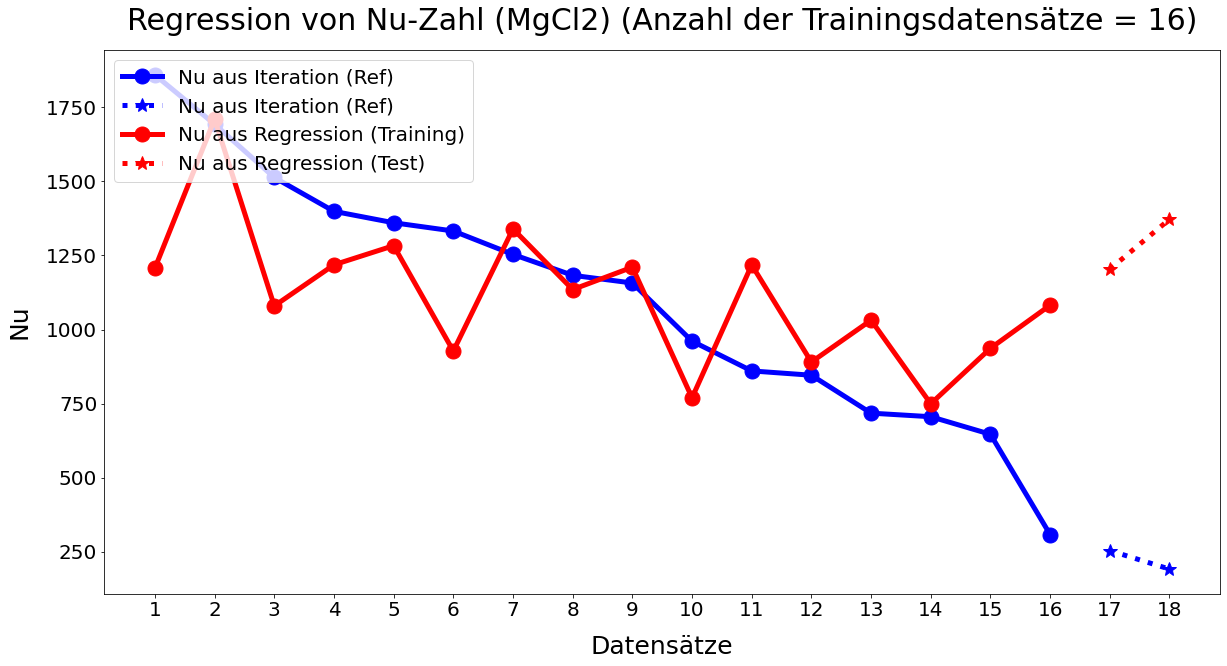

In [62]:
num_train = 16

df_Mg_selected_cool_sorted = df_Mg_select_cool.sort_values(by="Nu", ascending=False)

Nu_Mg_15 = regress_Nu(df_Mg_selected_cool_sorted.head(num_train), iter_num=20000)

Nu_Mg_sim = func_Nu(df_Mg_selected_cool_sorted, Nu_Mg_15[0], Nu_Mg_15[1],\
       Nu_Mg_15[2], Nu_Mg_15[3],\
       Nu_Mg_15[4], Nu_Mg_15[5])

df_compare_Nu = pd.DataFrame(list(zip(df_Mg_selected_cool_sorted.Nu, Nu_Mg_sim)), \
                             columns=['real', 'sim'])
df_compare_Nu.index = df_compare_Nu.index+1

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_compare_Nu.real[0:num_train], color = 'blue',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.real[num_train:], color = 'blue',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.sim[0:num_train], color = 'red',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Regression (Training)')
ax.plot(df_compare_Nu.sim[num_train:], color = 'red',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Regression (Test)')

ax.tick_params(labelsize = 20)

ax.set_xticks(np.arange(1,19))
ax.set_xlabel("Datensätze", size = 25, labelpad = 15)
ax.set_ylabel("Nu", size = 25, labelpad = 15)

ax.set_title('Regression von Nu-Zahl (MgCl2) (Anzahl der Trainingsdatensätze = {})'.format(num_train), size = 30, pad = 20)


plt.legend(loc = "upper left",fontsize = 20)
# plt.savefig("./bilder/Mg_Nu_{}.png".format(num_train), dpi = 300, tranparent=True)

#### Mg_Sh

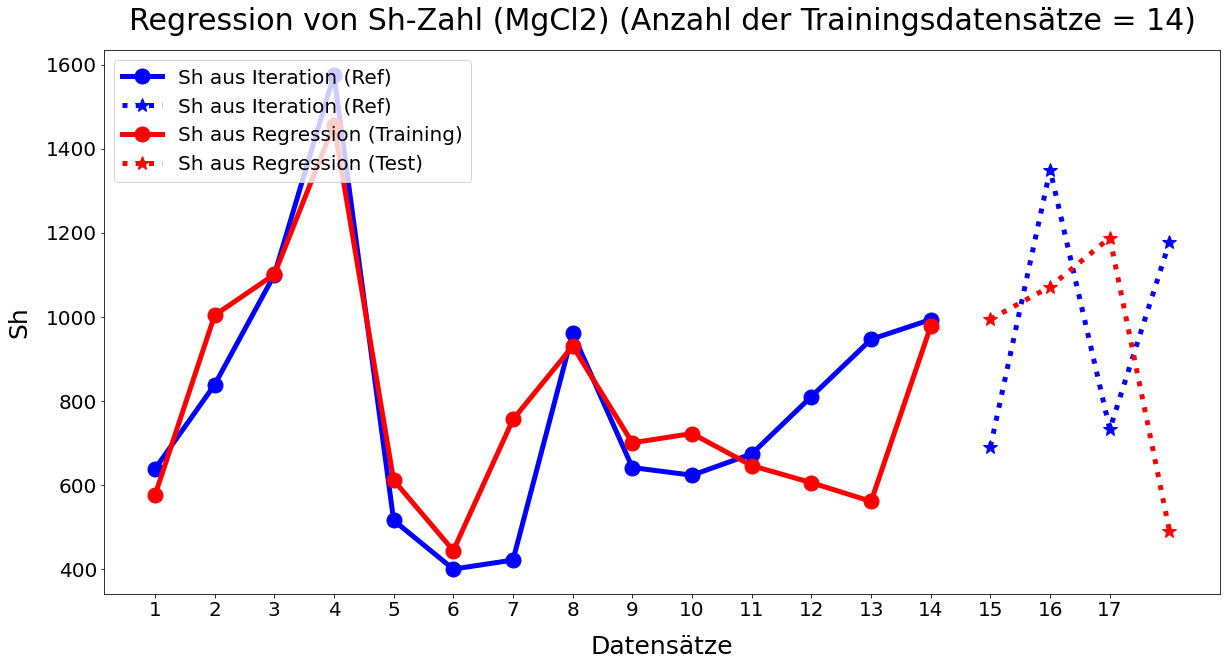

In [54]:
num_train = 14

Sh_Mg_15 = regress_Sh(df_Mg_select_cool.head(num_train), iter_num=20000)

Sh_Mg_sim = func_Sh(df_Mg_select_cool, Sh_Mg_15[0], Sh_Mg_15[1],\
       Sh_Mg_15[2], Sh_Mg_15[3],\
       Sh_Mg_15[4], Sh_Mg_15[5])

df_compare_Sh = pd.DataFrame(list(zip(df_Mg_select_cool.Sh, Sh_Mg_sim)), \
                             columns=['real', 'sim'])
df_compare_Sh.index = df_compare_Sh.index+1

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_compare_Sh.real[0:num_train], color = 'blue',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Sh aus Iteration (Ref)')
ax.plot(df_compare_Sh.real[num_train:], color = 'blue',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Sh aus Iteration (Ref)')
ax.plot(df_compare_Sh.sim[0:num_train], color = 'red',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Sh aus Regression (Training)')
ax.plot(df_compare_Sh.sim[num_train:], color = 'red',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Sh aus Regression (Test)')

ax.tick_params(labelsize = 20)

ax.set_xticks(np.arange(1,18))
ax.set_xlabel("Datensätze", size = 25, labelpad = 15)
ax.set_ylabel("Sh", size = 25, labelpad = 15)

ax.set_title('Regression von Sh-Zahl (MgCl2) (Anzahl der Trainingsdatensätze = {})'.format(num_train), size = 30, pad = 20)


plt.legend(loc = "upper left",fontsize = 20)
# plt.savefig("./bilder/Mg_Sh_{}.png".format(num_train), dpi = 300, tranparent=True)

## Regression with log + Scikit-learn

In [231]:
output_path_Li

'C:\\Users\\guwang\\GIT\\EnBA_M\\BrineGrid_HDisNet\\modelica_results\\Aug_23_2020_Calibration_Chen_2016'

In [232]:
df_Li_corr = pd.read_csv(filepath_or_buffer=output_path_Li+'\\final_output.csv').drop(columns = ["Unnamed: 0"])

In [234]:
df_Li_corr

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,T_d_o_sim,...,x_a_o_sim,Nu,Sh,T_a_o_sim_new,x_a_o_sim_new,xi_d_out,x_d_in_equ,Re,Pr,Sc
0,298.75,0.0162,1.85,288.05,0.2300,2.61,292.35,0.0091,294.45,20.19,...,9.29,3.221012,3.255806,292.457184,0.009092,0.228848,0.007228,897.028878,0.723822,0.616835
1,301.75,0.0202,1.87,291.35,0.2400,2.63,296.05,0.0116,298.35,24.45,...,11.41,3.146775,1.965057,295.896729,0.012749,0.238541,0.008621,901.585670,0.727614,0.617514
2,297.35,0.0160,1.98,290.85,0.3007,2.85,294.05,0.0077,297.05,23.22,...,7.88,4.421589,2.340150,292.651276,0.006107,0.298976,0.006254,963.424599,0.723793,0.616603
3,298.25,0.0152,1.94,291.25,0.3052,2.90,294.45,0.0075,297.25,23.27,...,7.61,4.399534,3.821553,294.417114,0.007286,0.303636,0.006259,941.424700,0.722846,0.616694
4,298.35,0.0143,1.95,290.95,0.3182,2.85,294.25,0.0069,297.05,23.08,...,7.02,4.682485,3.722464,294.138702,0.006704,0.316597,0.005690,945.628679,0.721900,0.616654
5,298.75,0.0143,1.93,291.55,0.3312,2.88,294.75,0.0066,297.65,23.72,...,6.84,4.925661,3.725612,294.657288,0.006421,0.329500,0.005458,934.970118,0.721849,0.616717
6,300.65,0.0181,1.92,290.85,0.2550,2.65,295.05,0.0099,297.45,23.69,...,10.08,3.753491,4.059564,294.904022,0.010961,0.253494,0.007838,927.325325,0.725560,0.617236
7,303.15,0.0177,1.89,292.05,0.2600,2.66,296.65,0.0097,298.95,24.74,...,10.22,3.223474,3.906512,296.837738,0.009668,0.258530,0.008284,906.929631,0.724833,0.617582
8,300.75,0.0164,1.92,290.45,0.2700,2.67,294.75,0.0087,296.85,23.10,...,9.03,3.553587,3.610193,294.830048,0.008668,0.268513,0.007133,926.330979,0.723778,0.617154
9,294.85,0.0108,2.04,282.65,0.2513,2.93,287.25,0.0057,287.75,14.13,...,5.81,3.224658,3.748884,287.394714,0.005689,0.250411,0.004611,996.633523,0.718731,0.615837


In [216]:
df_Li_reg_test["Nu_liter"] = Nu_Li_liter
df_Li_reg_test["Sh_liter"] = Sh_Li_liter

In [206]:
liter_Li_Nu = [4.7756e-5, 1.7936, 0.3333, -1.001, 0.8198, 0.3846]

In [239]:
liter_Li_Nu2 = [5,-0.9, -32, -2.68, 0.973, 27.06]

In [209]:
liter_Li_Sh = [7.3492e-7, 2.1576, 0.3333, 0.5235, -0.8956, 0.2376]

In [240]:
Nu_Li_liter = func_Nu(df_Li_reg, \
                    liter_Li_Nu2[0], liter_Li_Nu2[1], \
                    liter_Li_Nu2[2], liter_Li_Nu2[3], \
                    liter_Li_Nu2[4], liter_Li_Nu2[5])

In [241]:
Nu_Li_liter

array([26.11209926, 23.92519988, 40.09935395, 34.9319543 , 38.14660017,
       40.67274371, 37.84165228, 28.7157953 , 23.6329356 , 28.97606614,
       27.58001035, 33.00886186, 32.66124118, 37.60898599, 37.47575476])

In [ ]:
func_Nu()

In [210]:
Sh_Li_liter = func_Sh(df_Li_reg, \
                     liter_Li_Sh[0], liter_Li_Sh[1], \
                    liter_Li_Sh[2], liter_Li_Sh[3], \
                    liter_Li_Sh[4], liter_Li_Sh[5])

In [211]:
Sh_Li_liter

array([13.21610955, 12.94350067, 14.35476154, 14.36709385, 14.03484916,
       14.21902676, 13.52183979, 13.75829193, 14.01398079, 13.81613511,
       16.20698335, 13.41435282, 14.32828327, 14.35402034, 13.94734212])

In [67]:
df_Mg_reg

,T_a_in,x_a_in,m_a_in,T_d_in,x_d_in_equ,m_d_in,Re,Pr,Sc,Nu,Sh
0,298.02,0.009457,0.018848,287.44,0.004515,0.102670,4539.157604,0.716941,0.616288,717.608312,638.861733
1,300.51,0.012683,0.036283,292.20,0.006170,0.102670,8695.933155,0.719955,0.616900,1332.583590,839.122992
2,290.56,0.009162,0.046145,288.03,0.005896,0.104692,11331.652622,0.717612,0.614949,705.543257,1100.355742
3,289.91,0.010582,0.044123,283.27,0.004276,0.104691,10861.004609,0.719162,0.614945,960.727439,1575.898945
6,290.31,0.006337,0.018728,276.01,0.002552,0.104689,4596.168552,0.714750,0.614671,191.061995,516.598004
7,291.66,0.006289,0.018106,282.41,0.004029,0.104689,4427.450462,0.714521,0.614921,253.548841,400.798614
8,297.19,0.007873,0.043522,284.42,0.003572,0.049907,10496.096648,0.715421,0.616040,646.207204,422.315072
9,298.02,0.009022,0.032644,284.16,0.003614,0.102670,7860.215804,0.716494,0.616260,1253.443471,961.584649
10,298.77,0.007340,0.044014,283.13,0.003390,0.049666,10568.698862,0.714674,0.616280,1156.998993,642.245020
11,299.94,0.007566,0.050034,284.36,0.003825,0.049425,11979.266742,0.714759,0.616496,1360.420976,624.039899


In [235]:
def func_convert_df_log(df):
    df['log_Re'] = df['Re'].apply(math.log)
    df['log_Pr'] = df['Pr'].apply(math.log)
    df['log_Sc'] = df['Sc'].apply(math.log)
    df['log_m_frac'] = np.vectorize(lambda x,y: math.log(y/x))(df.m_a_in, df.m_d_in)
    df['log_x_frac'] = np.vectorize(lambda x,y: math.log(1-y/x))(df.x_a_in, df.x_d_in_equ)
    df['log_T_frac'] = np.vectorize(lambda x,y: math.log(y/x))(df.T_a_in, df.T_d_in)
    
    df['log_Nu'] = df['Nu'].apply(math.log)
    df['log_Sh'] = df['Sh'].apply(math.log)
    return df

In [236]:
def regr_via_sl(df, target):
    if target == "Nu":
        feature_cols = ['log_Re', 'log_Pr', 'log_m_frac', 'log_x_frac', 'log_T_frac']
    elif target == "Sc":
        feature_cols = ['log_Re', 'log_Sc', 'log_m_frac', 'log_x_frac', 'log_T_frac']
    else:
        raise Exception("target out of 'Nu' and 'Sc' are not allowed.")
    x = df[feature_cols]
    y = df['log_{}'.format(target)]
    
    lm = linear_model.LinearRegression()
    lm.fit(x,y)
    
    a_0 = math.exp(lm.intercept_)
    li_result = np.insert(lm.coef_, 0, a_0)
    return li_result

[ 5.94581073e+17  6.01909325e-01  1.24465662e+02 -1.51215898e-01
 -1.12530576e+00 -2.85896466e+01]


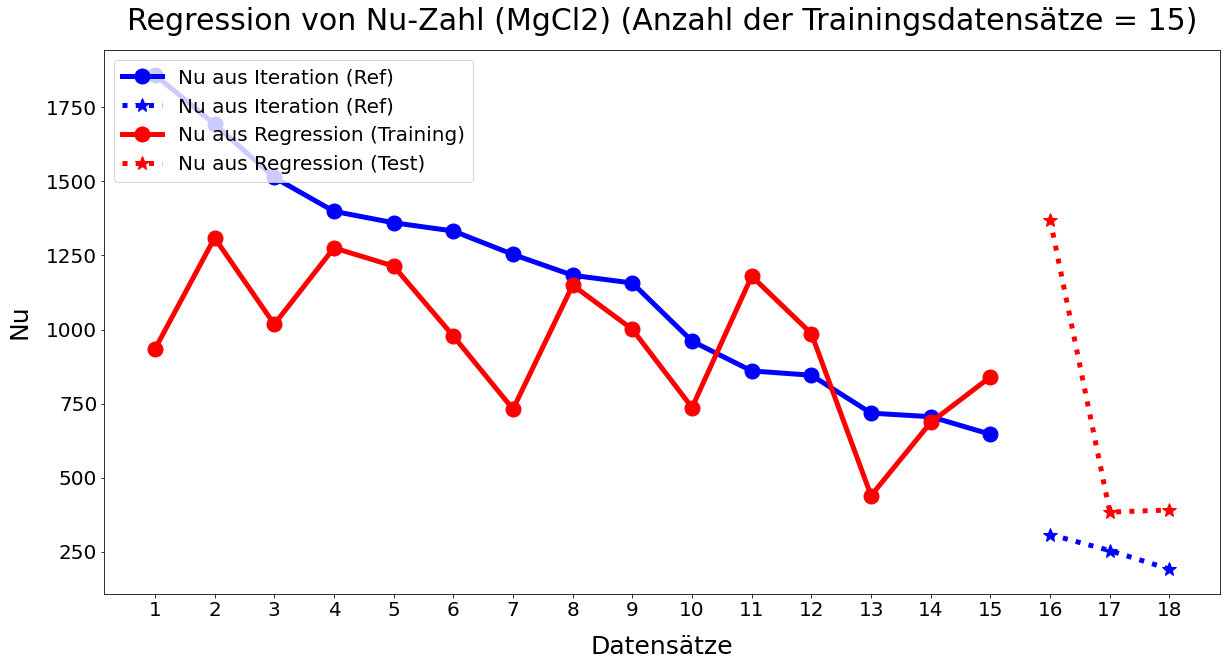

In [155]:
num_train = 15

df_Mg_selected_cool_sorted = df_Mg_select_cool.sort_values(by="Nu", ascending=False)
df_Mg_selected_cool_sorted_converted = func_convert_df_log(df_Mg_selected_cool_sorted)

results_reg_Mg = regr_via_sl(df_Mg_selected_cool_sorted_converted, 'Nu')
print(results_reg_Mg)

Nu_Mg_sim = func_Nu(df_Mg_selected_cool_sorted, \
                    results_reg_Mg[0], results_reg_Mg[1], \
                    results_reg_Mg[2], results_reg_Mg[3], \
                    results_reg_Mg[4], results_reg_Mg[5])

df_compare_Nu = pd.DataFrame(list(zip(df_Mg_selected_cool_sorted.Nu, Nu_Mg_sim)), \
                             columns=['real', 'sim'])
df_compare_Nu.index = df_compare_Nu.index+1

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_compare_Nu.real[0:num_train], color = 'blue',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.real[num_train:], color = 'blue',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.sim[0:num_train], color = 'red',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Regression (Training)')
ax.plot(df_compare_Nu.sim[num_train:], color = 'red',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Regression (Test)')

ax.tick_params(labelsize = 20)

ax.set_xticks(np.arange(1,19))
ax.set_xlabel("Datensätze", size = 25, labelpad = 15)
ax.set_ylabel("Nu", size = 25, labelpad = 15)

ax.set_title('Regression von Nu-Zahl (MgCl2) (Anzahl der Trainingsdatensätze = {})'.format(num_train), size = 30, pad = 20)


plt.legend(loc = "upper left",fontsize = 20)
# plt.savefig("./bilder/Mg_Nu_{}.png".format(num_train), dpi = 300, tranparent=True)

In [157]:
str(True)

'True'

In [188]:
Nu_Li_sim

array([3.45011442, 3.21417246, 4.68532907, 4.4044812 , 4.65626078,
       4.74950205, 4.82207223, 3.52934423, 3.0847058 , 3.58338469,
       3.24792485, 3.99434916, 3.91426347, 4.33326426, 4.57452728])

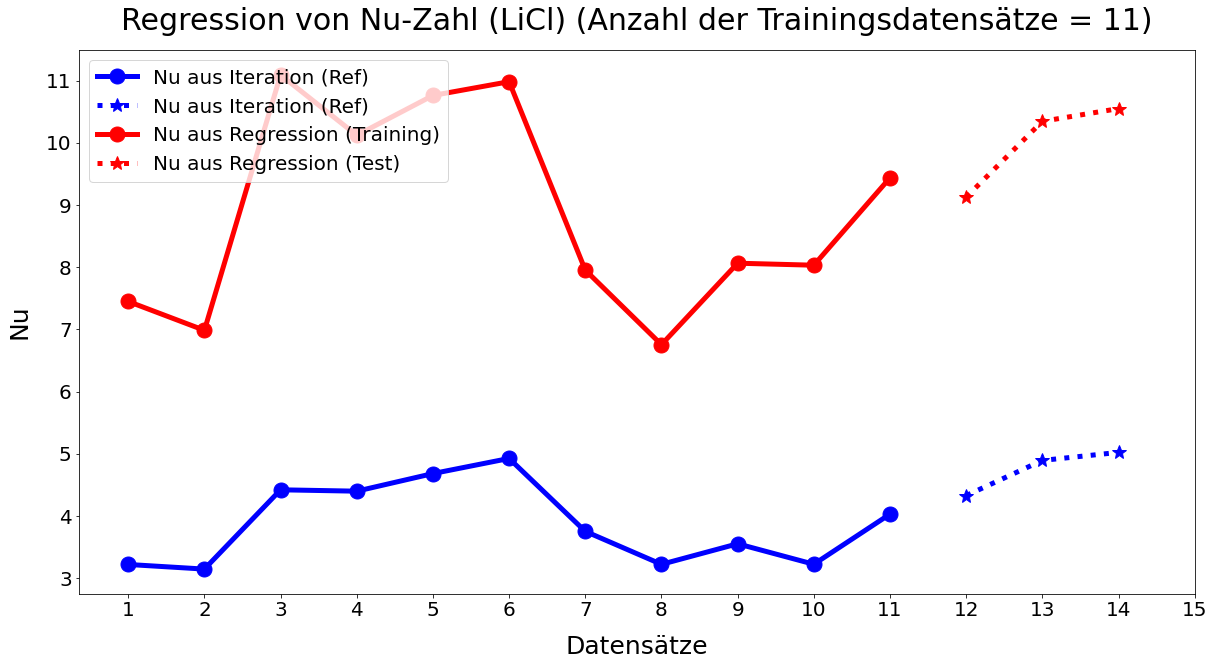

In [237]:
num_train = 11

results_reg_Nu = regr_via_sl(func_convert_df_log(df_Li_corr), target="Nu")

Nu_Li_sim = func_Nu(df_Li_corr, Nu_Li_15[0], Nu_Li_15[1],\
       Nu_Li_15[2], Nu_Li_15[3],\
       Nu_Li_15[4], Nu_Li_15[5])

df_compare_Nu = pd.DataFrame(list(zip(df_Li_corr.Nu, Nu_Li_sim)), \
                             columns=['real', 'sim'])
df_compare_Nu.index = df_compare_Nu.index+1

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(df_compare_Nu.real[0:num_train], color = 'blue',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.real[num_train:], color = 'blue',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Iteration (Ref)')
ax.plot(df_compare_Nu.sim[0:num_train], color = 'red',linewidth=5, \
        linestyle = '-', marker = 'o', markersize = 15, label = 'Nu aus Regression (Training)')
ax.plot(df_compare_Nu.sim[num_train:], color = 'red',linewidth=5, \
        linestyle = ':', marker = '*', markersize = 15, label = 'Nu aus Regression (Test)')

ax.tick_params(labelsize = 20)

ax.set_xticks(np.arange(1,16))
ax.set_xlabel("Datensätze", size = 25, labelpad = 15)
ax.set_ylabel("Nu", size = 25, labelpad = 15)

ax.set_title('Regression von Nu-Zahl (LiCl) (Anzahl der Trainingsdatensätze = {})'.format(num_train), size = 30, pad = 20)


plt.legend(loc = "upper left",fontsize = 20)
# plt.savefig("./bilder/Li_Nu_{}.png".format(num_train), dpi = 300, tranparent=True)

In [167]:
np_li = df_Li_reg.Nu.to_numpy()

In [163]:
import statistics

In [164]:
statistics.mean(df_Li_reg.Nu)

4.11379185561124

In [179]:
np.dot(np_li, 1)

array([3.2210125 , 3.14677474, 4.42158905, 4.39953414, 4.68248494,
       4.87712161, 4.925661  , 3.75349101, 3.22347387, 3.55358692,
       3.22465842, 4.0310708 , 4.32894015, 4.89391602, 5.02356268])

In [195]:
Nu_Li_sim[5:]

array([4.74950205, 4.82207223, 3.52934423, 3.0847058 , 3.58338469,
       3.24792485, 3.99434916, 3.91426347, 4.33326426, 4.57452728])

In [196]:
Nu_Li_sim

array([3.45011442, 3.21417246, 4.68532907, 4.4044812 , 4.65626078,
       4.74950205, 4.82207223, 3.52934423, 3.0847058 , 3.58338469,
       3.24792485, 3.99434916, 3.91426347, 4.33326426, 4.57452728])

## summarized function

In [198]:
df_raw = pd.read_csv(r"C:\Users\guwang\GIT\EnBA_M\BrineGrid_HDisNet\Extras\Python\exp_data\raw\raw_data_20_Aug.csv", sep = ";")

In [199]:
df_raw.head()

,time_start,time_stop,Ti03AIm,HT03AIm,HH03AIm,Ti03DIm,Fi03AIm,Fi01AOa,Rh03DIa,Fi03DIm,Ti03AOm,HT03AOm,HH03AOm,Col_num
0,dd/mm/yyyy hh:mm,dd/mm/yyyy hh:mm,K,K,%,K,m?/h,m?/h,kg/m?,l/min,K,K,%,-
1,13.06.2019 10:22,13.06.2019 10:28,297.96,298.02,48.26,287.44,0,57.63,1296.89,4.75,289.81,290.21,47.9,C_3
2,13.06.2019 13:15,13.06.2019 13:25,300.3,300.51,55.58,292.2,0,112.08,1296.88,4.75,295.05,294.81,54.06,C_3
3,18.06.2019 07:05,18.06.2019 07:25,298.27,298.02,46.07,284.16,99.79,0,1296.89,4.75,288.2,287.98,50.83,C_3
4,18.06.2019 11:55,18.06.2019 12:14,301.65,301.31,50.7,290.94,0,111.93,1296.87,4.75,293.97,293.69,52.19,C_3


In [200]:
df_raw.columns

Index(['time_start', 'time_stop', 'Ti03AIm', 'HT03AIm', 'HH03AIm', 'Ti03DIm',
       'Fi03AIm', 'Fi01AOa', 'Rh03DIa', 'Fi03DIm', 'Ti03AOm', 'HT03AOm',
       'HH03AOm', 'Col_num'],
      dtype='object')